In [2]:
# !pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [1]:
import sys
import torch
import torch.optim as optim
from detectron2.utils.events import (
    CommonMetricPrinter,
    EventStorage
)

from detectron2 import model_zoo
import detectron2.utils.comm as comm
from detectron2.modeling import build_model
from detectron2.data import transforms as T_
from detectron2.config import get_cfg
from detectron2.data.datasets.coco import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.data import DatasetMapper
from torch.utils.data import Dataset, DataLoader
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T_
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
    MapDataset,
    get_detection_dataset_dicts )
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.utils.logger import setup_logger

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
main_dir = '/content/drive/MyDrive/'
img_dir = 'data/face_mask_detection/images/'
ref_dir = 'data/face_mask_detection/'
panoptic_dir = 'Dataset/Panoptic'
semantic_dir = 'Dataset/Semantic'
model_dir = 'models/'

meta = {
    "thing_classes": ["with_mask", "without_mask", "mask_weared_incorrect"],
    "thing_colors": [[60, 179, 113], [75, 190, 123], [0, 240, 110]],
    "stuff_classes": ["Things", "Background"],
    "stuff_colors": [[82, 18, 128], [135, 206, 250]],
    "thing_dataset_id_to_contiguous_id": {1: 0, 2:1, 3:2},
    "stuff_dataset_id_to_contiguous_id": {0: 0, 1: 1},
}

In [50]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))
# cfg.MODEL.WEIGHTS = main_dir + model_dir + "model_final_f10217.pkl"
cfg.MODEL.WEIGHTS = main_dir + model_dir + 'mask_r50_face_mask_ep30.pth'

# Default is BGR as input although they internally convert it to RGB
cfg.INPUT.FORMAT = "RGB"

cfg.MODEL.DEVICE = "cuda"

# cfg.MODEL.PIXEL_MEAN = pix_mean
# cfg.MODEL.PIXEL_STD = pix_std

# #To use as Cascade
# cfg.MODEL.ROI_HEADS.NAME = "CascadeROIHeads"
# cfg.MODEL.ROI_BOX_HEAD.CLS_AGNOSTIC_BBOX_REG = True


cfg.MODEL.BACKBONE.FREEZE_AT = 2
cfg.MODEL.RESNETS.NORM = "GN"
cfg.MODEL.FPN.NORM = "GN"
cfg.MODEL.ROI_BOX_HEAD.NORM = "GN"
cfg.MODEL.ROI_MASK_HEAD.NORM = "GN"
# cfg.MODEL.SEM_SEG_HEAD.NORM = "GN"


cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
# cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 2

cfg.SOLVER.IMS_PER_BATCH = 2

# cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_TYPE = roi_box_head_loss
# cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_WEIGHT = float(roi_box_head_loss_weight)
# cfg.MODEL.RPN.BBOX_REG_LOSS_TYPE = rpn_loss
# cfg.MODEL.RPN.BBOX_REG_LOSS_WEIGHT = float(rpn_loss_weight)


cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.3


model = build_model(cfg)

DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)

model.to(device)

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(
      256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): GroupNorm(32, 256, eps=1e-05, affine=True)
    )
    (fpn_output2): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): GroupNorm(32, 256, eps=1e-05, affine=True)
    )
    (fpn_lateral3): Conv2d(
      512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): GroupNorm(32, 256, eps=1e-05, affine=True)
    )
    (fpn_output3): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): GroupNorm(32, 256, eps=1e-05, affine=True)
    )
    (fpn_lateral4): Conv2d(
      1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): GroupNorm(32, 256, eps=1e-05, affine=True)
    )
    (fpn_output4): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): GroupNorm(32, 256, eps=1e-05, affine=True)
    )


In [11]:
DatasetCatalog.clear()
MetadataCatalog.clear()

image_root = main_dir + img_dir
register_coco_instances(name="mask_train",
                          metadata=meta,
                          image_root=image_root,
                          json_file=main_dir + ref_dir + "coco_train_set.json")

# register_coco_instances(name="mask_val",
#                           metadata=meta,
#                           image_root=image_root,
#                           json_file=main_dir + ref_dir + "coco_val_set.json")


# register_coco_instances(name="mask_test",
#                           metadata=meta,
#                           image_root=image_root,
#                           json_file=main_dir + ref_dir + "coco_test_set.json")



## Dataset

train_aug_list = [T_.ResizeShortestEdge([272, 304, 336, 368, 400, 432],
                                        600, sample_style='choice'),
                  T_.RandomFlip()]

val_aug_list = [T_.ResizeShortestEdge([432, 432], 600, sample_style='choice')]

train_dataset = get_detection_dataset_dicts(["mask_train"])

train_dataset = MapDataset(train_dataset, DatasetMapper(cfg, augmentations=train_aug_list,
                                                        is_train=True, image_format="RGB"))

# val_dataset = get_detection_dataset_dicts(["mask_val"])

# val_dataset = MapDataset(val_dataset, DatasetMapper(cfg, augmentations=val_aug_list,
#                                                         is_train=True, image_format="RGB"))

# test_dataset = get_detection_dataset_dicts(["mask_test"])

# test_dataset = MapDataset(test_dataset, DatasetMapper(cfg, augmentations=val_aug_list,
#                                                         is_train=True, image_format="RGB"))


## DataLoader
def collate_fn(batch):
    return batch

train_dataloader = DataLoader(train_dataset, batch_size=2, collate_fn=collate_fn, shuffle=True)

# val_dataloader = DataLoader(val_dataset, batch_size=1, collate_fn=collate_fn, shuffle=False)

# test_dataloader = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn, shuffle=False)

In [ ]:
writers = (
    [ CommonMetricPrinter(427) ]   #1071
    if comm.is_main_process()
    else []
)

optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
setup_logger()    #Start Detectron2 logger


def train_one_epoch(model, dataloader):

    with EventStorage(0) as storage:
        for batch_idx, items in enumerate(dataloader):

            storage.step()

            loss_dict = model(items)

            losses = sum(loss_dict.values())
            assert torch.isfinite(losses).all(), loss_dict

            loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())
            if comm.is_main_process():
                storage.put_scalars(total_loss=losses_reduced, **loss_dict_reduced)


            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
            # scheduler.step()
          
            if ( batch_idx % 20 ) == 0 :
              # print(batch_idx)
              for writer in writers:
                writer.write()


    return model



def test_model(model, dataloader):
    img = ""
    outputs = ""
    results = []

    with torch.no_grad():
        model.eval()
      
        for idx, items in enumerate(dataloader):

            outputs = model(items)

            boxes = outputs[0]["instances"].get_fields()["pred_boxes"].tensor.detach().cpu().numpy()
            scores = outputs[0]["instances"].get_fields()["scores"].detach().cpu().numpy()
            classes = outputs[0]["instances"].get_fields()["pred_classes"].detach().cpu().numpy()

            for idx, bbox in enumerate(boxes):
                bbox = list(bbox)

                result = {
                    "image_id": items[0]["image_id"],
                    "bbox": [bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]],
                    "category_id": classes[idx],
                    "score": scores[idx]
                }

                results.append(result)


        if len(results) > 0:
            #Coco eval
            coco_gt = COCO(main_dir + ref_dir + "coco_val_set.json")
            coco_dt = coco_gt.loadRes(results)

            annType = 'bbox'
            coco_eval = COCOeval(coco_gt, coco_dt, annType)

            coco_eval.evaluate()
            coco_eval.accumulate()
            coco_eval.summarize()

            # #For result_df
            # summary = Summarize(coco_eval.stats, coco_eval.params, coco_eval.eval)
            # #Returns an array of size 20
            # summary_dets = summary.summarizeDets()

            # results_df.loc[len(results_df)] = summary_dets

            # with open(main_dir + ref_dir + "coco_results_ic13.json", "w+") as f:
            #     json.dump(results, f)


for epoch in range(30):
    #### Training
    print("Epoch {} begins".format(epoch + 1))
    model.train()


    model = train_one_epoch(model, train_dataloader)

    # #Validation
    # print("Epoch {} validation results : ".format(epoch + 1))
    # test_model(model, val_dataloader)


Epoch 1 begins
[09/13 18:24:55 d2.utils.events]:  iter: 1  total_loss: 2.742  loss_cls: 1.5  loss_box_reg: 0.003889  loss_mask: 0.6958  loss_rpn_cls: 0.3693  loss_rpn_loc: 0.1729  lr: 0.03  max_mem: 1546M
[09/13 18:25:15 d2.utils.events]:  eta: 0:06:40  iter: 21  total_loss: 1.13  loss_cls: 0.2135  loss_box_reg: 0.05978  loss_mask: 0.4152  loss_rpn_cls: 0.2256  loss_rpn_loc: 0.04363  lr: 0.03  max_mem: 2210M
[09/13 18:25:34 d2.utils.events]:  eta: 0:06:09  iter: 41  total_loss: 1.022  loss_cls: 0.1679  loss_box_reg: 0.03786  loss_mask: 0.2939  loss_rpn_cls: 0.3305  loss_rpn_loc: 0.1693  lr: 0.03  max_mem: 2210M
[09/13 18:25:53 d2.utils.events]:  eta: 0:05:51  iter: 61  total_loss: 0.761  loss_cls: 0.08714  loss_box_reg: 0.02703  loss_mask: 0.2974  loss_rpn_cls: 0.2284  loss_rpn_loc: 0.05294  lr: 0.03  max_mem: 2210M
[09/13 18:26:11 d2.utils.events]:  eta: 0:05:11  iter: 81  total_loss: 0.9338  loss_cls: 0.1113  loss_box_reg: 0.04549  loss_mask: 0.4011  loss_rpn_cls: 0.2257  loss_rpn_lo

In [ ]:
torch.save(model.state_dict(),  main_dir + model_dir + 'mask_r50_face_mask_ep30.pth')

# Display the output on the image

In [57]:
#Display the output on the image
import cv2
import imgaug as ia
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from PIL import Image

model.eval()

img = cv2.imread(main_dir + img_dir + "maksssksksss2.png")
img_tensor = torch.tensor(img.transpose(2, 0, 1).astype("float32"))
item = [{"image" : img_tensor}]
# # item = item.to(device)

outputs = model(item)

boxes = outputs[0]["instances"].get_fields()["pred_boxes"].tensor.detach().cpu().numpy()
scores = outputs[0]["instances"].get_fields()["scores"].detach().cpu().numpy()
classes = outputs[0]["instances"].get_fields()["pred_classes"].detach().cpu().numpy()

bbox_list = []
for box in boxes:
  bbox_xyxy = BoundingBox(x1=box[0], y1=box[1], x2=box[2], y2=box[3])
  bbox_list.append(bbox_xyxy)

category_box = BoundingBoxesOnImage(bbox_list, shape=img.shape)
output_image = category_box.draw_on_image(img, size=4)

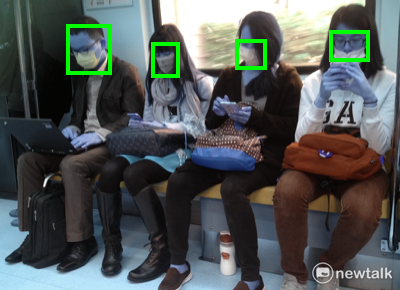

In [58]:
img_pil = Image.fromarray(output_image)
img_pil